In [1]:
###################################################################################
# notebook for comparing some model reults. This will bedone both for the differences
# between the model concatenation methods, and for the differences in background samples
# used for shap calculations
###################################################################################

In [2]:
import datetime
import gc
import glob
import json
import math
import os
import pickle
import subprocess
import time

import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm
from scipy.special import expit, inv_boxcox
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from spacepy import pycdf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.backend import get_session

import utils

2024-01-24 14:13:45.533908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 14:13:54.495136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# First the SHAP Values

In [3]:
# listing the regions that have finished calculating both sets of SHAP values
shap_regions = [14, 321]

In [4]:
region_dict = {}

for region in shap_regions:
	with open(f"outputs/shap_values/twins_region_{region}_evaluation_dict.pkl", "rb") as f:
		less_shap = pickle.load(f)

	with open(f"outputs/shap_values/full_twins_region_{region}_evaluation_dict.pkl", "rb") as g:
		more_shap = pickle.load(g)

	with open(f"models/rsd/twins_region_{region}_version_final_scaler.pkl", "rb") as f:
		scaler = pickle.load(f)

	region_dict[region] = {"less_shap": less_shap, "more_shap": more_shap, "scaler": scaler}

In [5]:
less, more, test, diff = [], [], [], []

for reg in region_dict.keys():
	less_shap = region_dict[reg]["less_shap"]
	more_shap = region_dict[reg]["more_shap"]
	print(len(less_shap['2012-03-07']['shap_values']))
	test_stacked = np.array([scaler['twins'].inverse_transform(less_shap['2012-03-07']['twins_test'][i, :, :, 0]) \
														for i in range(less_shap['2012-03-07']['twins_test'].shape[0])])
	less_stacked = np.vstack([less_shap['2012-03-07']["shap_values"][i][0][1][:, :, :, 0] \
														for i in range(len(less_shap['2012-03-07']['shap_values']))])
	more_stacked = np.vstack([more_shap['2012-03-07']["shap_values"][i][0][1][:, :, :, 0] \
														for i in range(len(more_shap['2012-03-07']['shap_values']))])
	difference = np.vstack([more_shap["2012-03-07"]["shap_values"][i][0][1][:, :, :, 0] - less_shap["2012-03-07"]["shap_values"][i][0][1][:, :, :, 0] \
							for i in range(len(more_shap["2012-03-07"]["shap_values"]))])

	less.append(less_stacked)
	more.append(more_stacked)
	test.append(test_stacked)
	diff.append(difference)

less = np.vstack(less)
more = np.vstack(more)
test = np.vstack(test)
diff = np.vstack(diff)

626
626


In [17]:
region_dict[14]["less_shap"]["2012-03-07"].keys()
old_concat = pd.read_feather(f"outputs/rsd/twins_modeling_region_{region}_version_final.feather")
old_concat.set_index('dates', inplace=True)
print(old_concat.columns)


Index(['predicted_mean', 'predicted_std', 'actual'], dtype='object')


In [ ]:
sum_less = np.sum(np.sum(less, axis=1), axis=1)
sum_more = np.sum(np.sum(more, axis=1), axis=1)

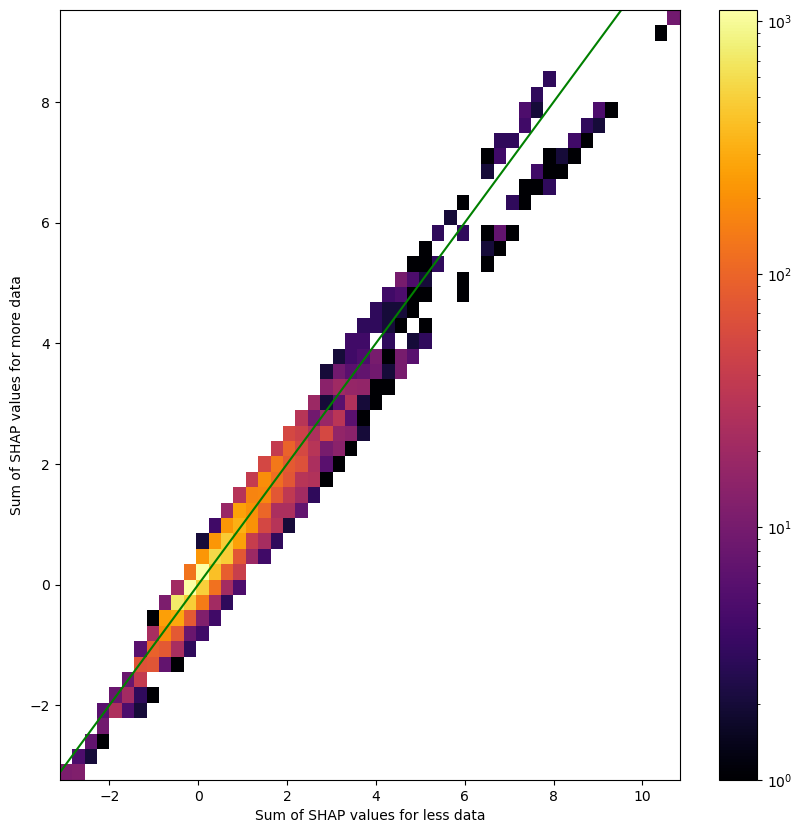

In [ ]:
plt.figure(figsize=(10, 10))
plt.hist2d(sum_less, sum_more, bins=50, cmap="inferno", norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot([-10, 1000], [-10, 1000], color="green")
plt.xlabel("Sum of SHAP values for less data")
plt.ylabel("Sum of SHAP values for more data")
plt.show()

In [ ]:
print(less.shape)
print(less.shape)
print(test.shape)
print(diff.shape)

(12510, 90, 60)
(12510, 90, 60)
(12510, 90, 60)
(12510, 90, 60)


In [ ]:
diff_df = pd.DataFrame({"energy": test.flatten(), "difference": diff.flatten()})
less_df = pd.DataFrame({"energy": test.flatten(), "difference": less.flatten()})
more_df = pd.DataFrame({"energy": test.flatten(), "difference": more.flatten()})

diff_df = diff_df.groupby(pd.cut(diff_df.energy, np.arange(0, 70, 1))).mean()
less_df = less_df.groupby(pd.cut(less_df.energy, np.arange(0, 70, 1))).mean()
more_df = more_df.groupby(pd.cut(more_df.energy, np.arange(0, 70, 1))).mean()

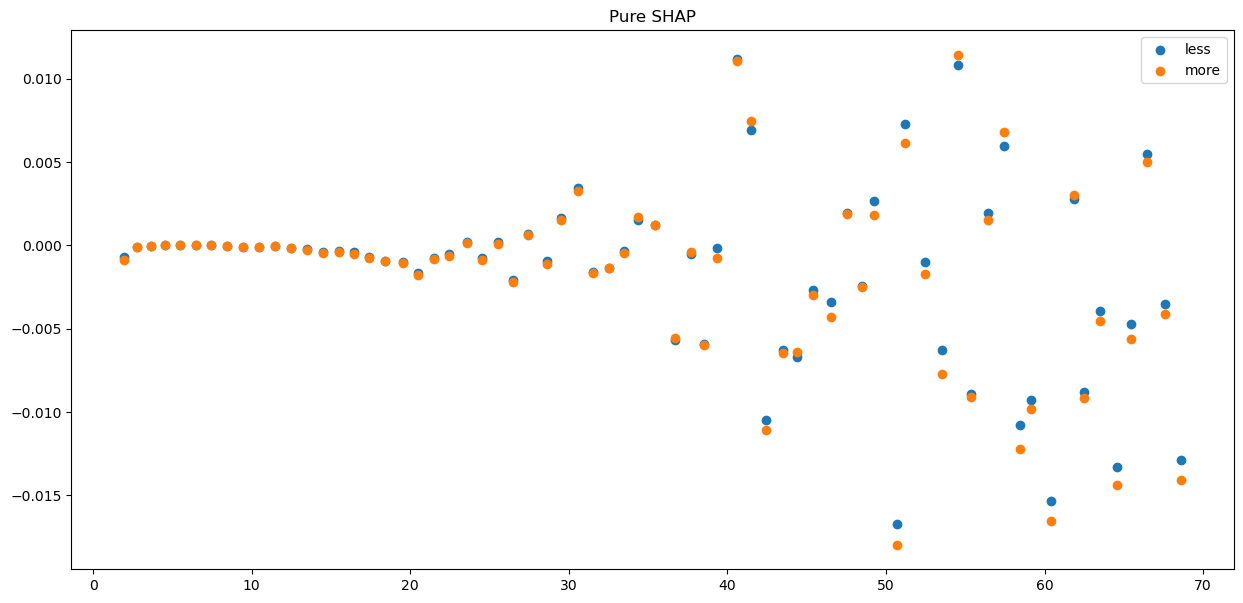

In [ ]:
fig,axes = plt.subplots(1,1, figsize=(15,7))
axes.scatter(less_df['energy'], less_df['difference'], label='less')
axes.scatter(more_df['energy'], more_df['difference'], label='more')
axes.legend()
axes.set_title('Pure SHAP')
# axes[1].scatter(diff_df['energy'], diff_df['difference'])
# axes[1].set_title('Difference')
plt.show()

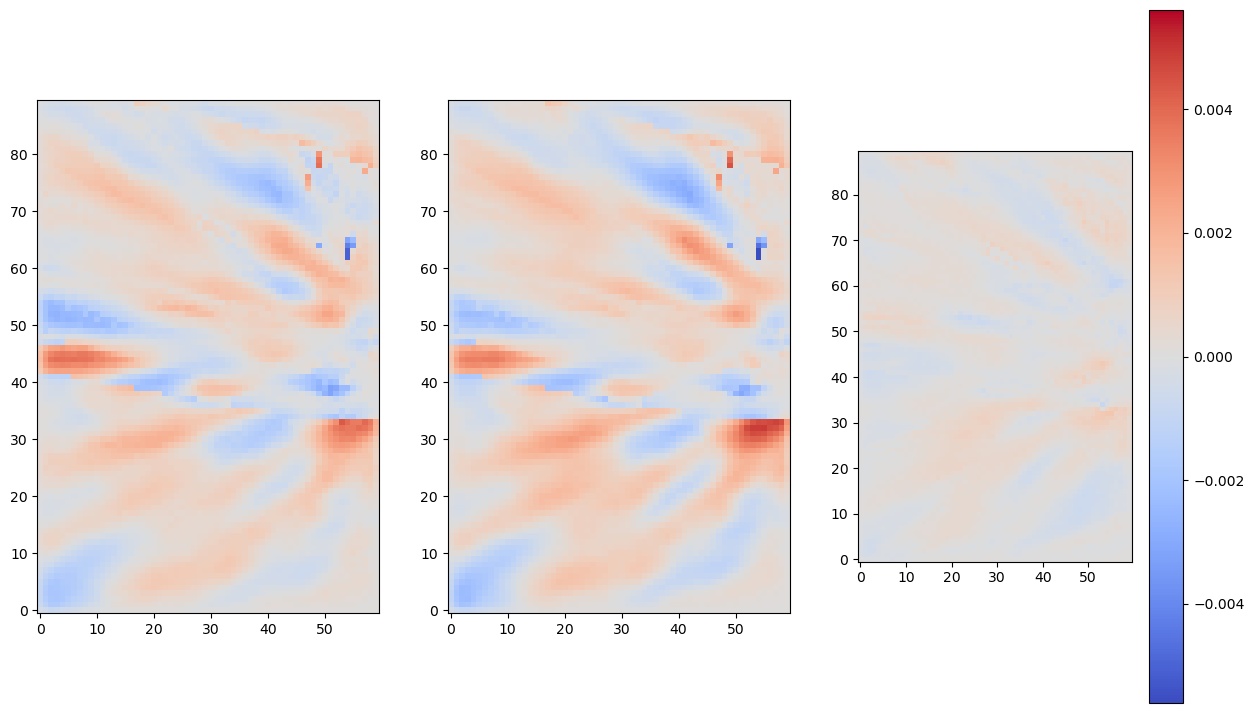

In [ ]:
i = 500
# plotting two of the maps next to one another and the differnece between them
fig, ax = plt.subplots(1, 3, figsize=(15, 9))
vmax = np.max([np.max(less_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0]), np.max(more_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0])])
vmin = np.min([np.min(less_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0]), np.min(more_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0])])
largest = max(abs(vmax), abs(vmin))
less_cbar = ax[0].imshow(less_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0], vmin=-largest, vmax=largest, cmap='coolwarm', origin='lower')
more_cbar = ax[1].imshow(more_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0], vmin=-largest, vmax=largest, cmap='coolwarm', origin='lower')
difference = more_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0] - less_shap["2012-03-07"]["shap_values"][i][0][1][0, :, :, 0]
diff_max = max(abs(np.min(difference)), abs(np.max(difference)))
cbar_ax = ax[2].imshow(difference, vmin=-largest, vmax=largest, cmap='coolwarm', origin='lower')
# cbar = ax[0].figure.colorbar(less_cbar, ax=ax[0])
cbar = ax[2].figure.colorbar(cbar_ax, ax=ax[2])

plt.show()

In [ ]:
trained_regions = [9, 16, 19, 82, 83, 143, 163, 223, 270, 387]

In [ ]:
region = 82

new_concat = pd.read_feather(f"outputs/rsd/twins_modeling_region_{region}_version_final_new_concat.feather")
new_concat.set_index('dates', inplace=True)

old_concat = pd.read_feather(f"outputs/rsd/twins_modeling_region_{region}_version_final.feather")
old_concat.set_index('dates', inplace=True)

In [ ]:
plotting_new = new_concat['2012-03-07':'2012-03-08']
plotting_old = old_concat['2012-03-07':'2012-03-08']

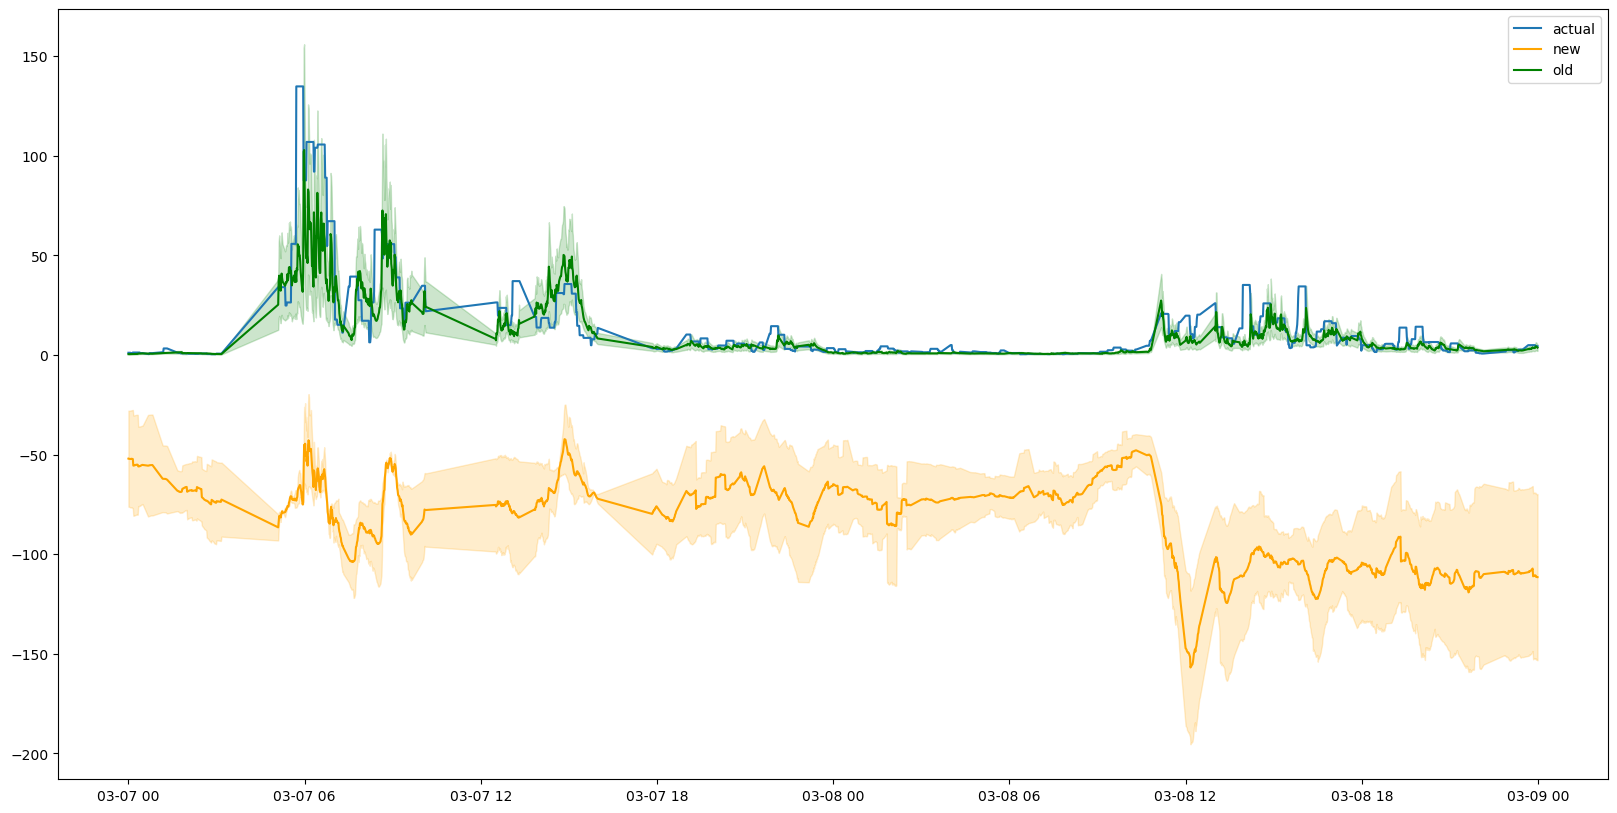

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(20,10))
plt.plot(plotting_new['actual'], label='actual')
plt.plot(plotting_new['predicted_mean'], label='new', color='orange')
plt.fill_between(plotting_new.index, plotting_new['predicted_mean'] - plotting_new['predicted_std'], plotting_new['predicted_mean'] + plotting_new['predicted_std'], alpha=0.2, color='orange')

plt.plot(plotting_old['predicted_mean'], label='old', color='green')
plt.fill_between(plotting_old.index, plotting_old['predicted_mean'] - plotting_old['predicted_std'], plotting_old['predicted_mean'] + plotting_old['predicted_std'], alpha=0.2, color='green')

plt.legend()
plt.show()

In [ ]:
print(np.sqrt(mean_squared_error(new_concat['actual'], new_concat['predicted_mean'])))
print(np.sqrt(mean_squared_error(old_concat['actual'], old_concat['predicted_mean'])))

16.364284917522166
12.874740412971502


In [ ]:
print(new_concat['predicted_std'].mean())
print(old_concat['predicted_std'].mean())

13.796675682067871
4.27409029006958
